In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mne import read_epochs
from mrmr import mrmr_classif
from ReliefF import ReliefF
from sklearn import svm
from sklearn.feature_selection import RFE
from random import randint

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import kurtosis, skew, moment, entropy, norm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import  StratifiedKFold, cross_val_score, GridSearchCV
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
hbo = read_epochs('hbo_epo.fif')
hbr = read_epochs('hbr_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\mrl\hbo_epo.fif ...
    Found the data of interest:
        t =   -4992.00 ...   19968.00 ms
        0 CTF compensation matrices available
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Alberto\Documents\BCI\data\mrl\hbr_epo.fif ...
    Found the data of interest:
        t =   -4992.00 ...   19968.00 ms
        0 CTF compensation matrices available
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


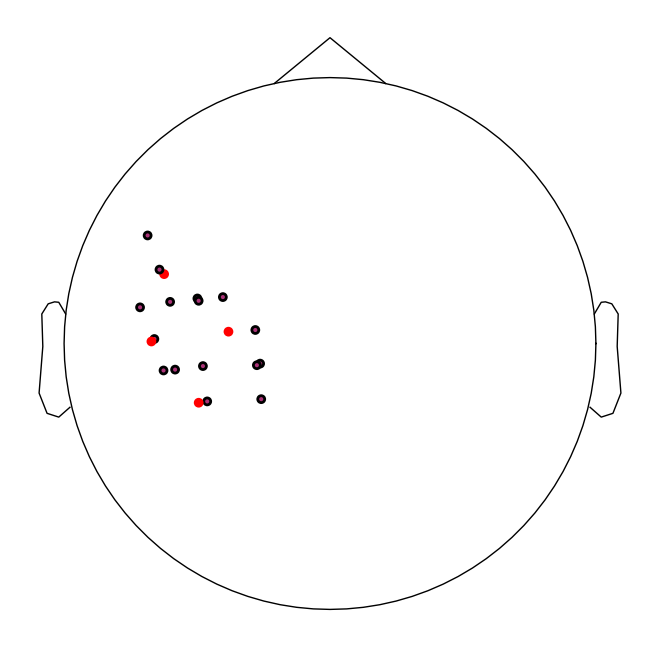

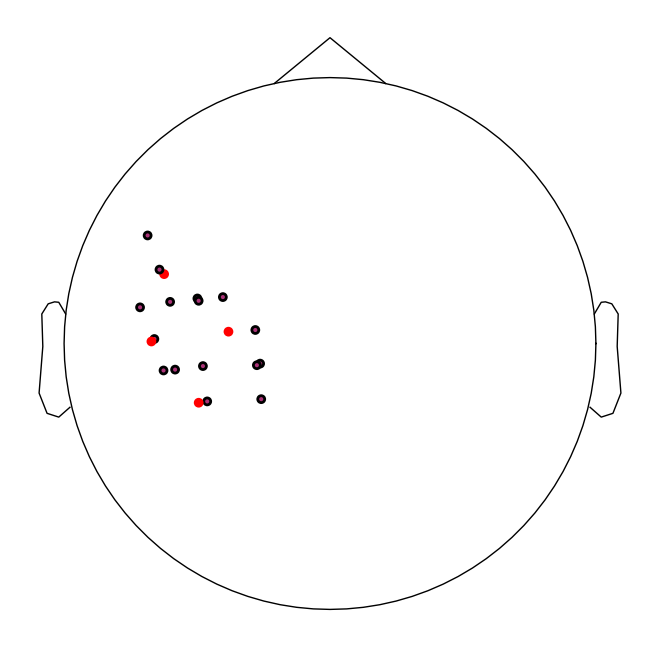

In [4]:
hbo.plot_sensors()

In [3]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
rf = RandomForestClassifier(random_state=0)
svm_rbf = svm.SVC(kernel="rbf")
knn = KNeighborsClassifier(n_neighbors=3)
relief = ReliefF(n_neighbors=3, n_features_to_keep=6)
pca = PCA(n_components=.9)
le = LabelEncoder()

In [4]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def energy(x):
    return sum(x**2)

def med_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def calc_centroid(x, fs=7.81):
    energy = np.array(x) ** 2
    t = range(len(x))
    t = [float(x) / fs for x in t]
    t_energy = np.dot(np.array(t), np.array(energy))
    energy_sum = np.sum(energy)

    if energy_sum == 0 or t_energy == 0:
        centroid = 0
    else:
        centroid = t_energy / energy_sum

    return centroid

left vs rest

In [6]:
conditions = ['left','rest']
hbo_sub = hbo[conditions].copy()
hbr_sub = hbr[conditions].copy()

hbo_sub.drop_channels(hbo_sub.info['bads'])
hbr_sub.drop_channels(hbr_sub.info['bads'])
y = le.fit_transform(hbr_sub.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

t_min = 1
t_max = 9

hbo_sub = hbo_sub.copy().crop(t_min,t_max).get_data()
hbr_sub = hbr_sub.copy().crop(t_min,t_max).get_data()

In [58]:
#CAR
hbo_avg = np.mean(hbo_sub, axis=0, keepdims=True)
hbr_avg = np.mean(hbr_sub, axis=0, keepdims=True)

hbo_sub = hbo_sub - hbo_avg
hbr_sub = hbr_sub - hbr_avg

train_data = np.concatenate([hbo_sub,  hbr_sub], axis=1)

In [59]:
print(genConf(train_data.shape[0], 0.01))
print(genConf(train_data.shape[0], 0.05))

69.94104659775164
65.63230694286008


In [45]:
test_time_windows('lda','mrmr')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.11it/s]


0.825  from 0  to  6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09it/s]


0.8375  from 0  to  7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62it/s]


0.88125  from 0  to  8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.94it/s]


0.9  from 0  to  9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


0.9125  from 1  to  9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


In [39]:
conditions = ['left','right']
hbo_sub = hbo[conditions].copy().apply_baseline((-5,0))
hbr_sub = hbr[conditions].copy().apply_baseline((-5,0))

hbo_sub.drop_channels(hbo_sub.info['bads'])
hbr_sub.drop_channels(hbr_sub.info['bads'])
y = le.fit_transform(hbr_sub.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

t_min = 0
t_max = 20

hbo_sub = hbo_sub.copy().crop(t_min,t_max).get_data()
hbr_sub = hbr_sub.copy().crop(t_min,t_max).get_data()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [40]:
#CAR
hbo_avg = np.mean(hbo_sub, axis=0, keepdims=True)
hbr_avg = np.mean(hbr_sub, axis=0, keepdims=True)

hbo_sub = hbo_sub - hbo_avg
hbr_sub = hbr_sub - hbr_avg

train_data = np.concatenate([hbo_sub,  hbr_sub], axis=1)

In [66]:
print(genConf(train_data.shape[0], 0.01))
print(genConf(train_data.shape[0], 0.05))

69.94104659775162
65.63230694286007


In [14]:
test_time_windows('lda','mrmr')

1 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.16it/s]


0.7352941176470588 std 0.04460514967089144  from 1  to  7
1 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41it/s]


1 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.05it/s]


0.775 std 0.049999999999999996  from 1  to  9
1 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.90it/s]


0.8 std 0.046770717334674264  from 1  to  10
1 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.84it/s]


1 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.73it/s]


0.8375 std 0.05  from 1  to  12
1 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.73it/s]


1 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.79it/s]


1 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.56it/s]


1 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.30it/s]


1 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.47it/s]


1 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.56it/s]


2 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.54it/s]


2 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]


2 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.95it/s]


2 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.48it/s]


2 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.15it/s]


2 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.70it/s]


2 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.53it/s]


In [41]:
selected_features, single_score = get_informative_features(1, 10)
selected_features = np.concatenate(selected_features)
np.save('single_fnirs_features', selected_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.90it/s]


mean accuracy:  0.8202205882352942 +- 0.06968730361742466


Rhythmn


In [37]:
conditions = ['r_pinch','r_stop']
hbo_sub = hbo[conditions].copy().apply_baseline((-5,0))
hbr_sub = hbr[conditions].copy().apply_baseline((-5,0))

hbo_sub.drop_channels(hbo_sub.info['bads'])
hbr_sub.drop_channels(hbr_sub.info['bads'])
y = le.fit_transform(hbr_sub.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

t_min = 0
t_max = 20

hbo_sub = hbo_sub.copy().crop(t_min,t_max).get_data()
hbr_sub = hbr_sub.copy().crop(t_min,t_max).get_data()

#CAR
hbo_avg = np.mean(hbo_sub, axis=0, keepdims=True)
hbr_avg = np.mean(hbr_sub, axis=0, keepdims=True)

hbo_sub = hbo_sub - hbo_avg
hbr_sub = hbr_sub - hbr_avg

train_data = np.concatenate([hbo_sub,  hbr_sub], axis=1)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [33]:
test_time_windows('lda','mrmr', shift = 5)

1 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.26it/s]


0.65 std 0.07217128079524635  from 6  to  12
1 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.11it/s]


0.6691176470588236 std 0.1191766375354501  from 6  to  13
1 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.41it/s]


1 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.84it/s]


0.763235294117647 std 0.08113596602431598  from 6  to  15
1 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.20it/s]


1 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.45it/s]


1 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.70it/s]


1 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.79it/s]


1 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76it/s]


1 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.25it/s]


1 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


1 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.08it/s]


2 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.76it/s]


2 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.76it/s]


2 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.53it/s]


2 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.49it/s]


0.7867647058823529 std 0.05771004961867229  from 7  to  16
2 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.08it/s]


2 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.28it/s]


2 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]


2 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.84it/s]


2 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]


KeyboardInterrupt: 

In [38]:
selected_features, rhytmn_score = get_informative_features(6, 15)
selected_features = np.concatenate(selected_features)
np.save('rhy_fnirs_features', selected_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.70it/s]


mean accuracy:  0.7492647058823529 +- 0.10023760698795277


In [42]:
np.save('nirs_scores', np.array([single_score, rhytmn_score]))

In [17]:
conditions = ['left','rest','right']
hbo_sub = hbo[conditions].copy()
hbr_sub = hbr[conditions].copy()

hbo_sub.drop_channels(hbo_sub.info['bads'])
hbr_sub.drop_channels(hbr_sub.info['bads'])
y = le.fit_transform(hbr_sub.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

t_min = 0
t_max = 20

hbo_sub = hbo_sub.copy().crop(t_min,t_max).get_data()
hbr_sub = hbr_sub.copy().crop(t_min,t_max).get_data()

#CAR
hbo_avg = np.mean(hbo_sub, axis=0, keepdims=True)
hbr_avg = np.mean(hbr_sub, axis=0, keepdims=True)

hbo_sub = hbo_sub - hbo_avg
hbr_sub = hbr_sub - hbr_avg

train_data = np.concatenate([hbo_sub,  hbr_sub], axis=1)

In [18]:
test_time_windows('lda','mrmr')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


0.5403985507246376  from 0  to  6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]


0.6123188405797102  from 0  to  7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


0.6224637681159421  from 0  to  8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.54it/s]


0.6365942028985507  from 0  to  11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]


0.65  from 0  to  13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


0.6885869565217392  from 1  to  10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


In [14]:
# compute conf level
def p(n):
    return (n*chance+2)/(n+4)
def conf(n,p,alpha):
    return np.sqrt((p*(1-p))/(n+4))*norm.ppf(1-(alpha/2))
def genConf(n, alpha):
    res = np.zeros((n))
    for i in range(0,n):
        res[i] = p(i) + conf(i, p(i), alpha)
    return res[-1]*100

In [27]:
def test_classification(classifier):
    pca_score = []
    rfe_score = []
    mrmr_score = []
    rf_score = []
    
    rfe_features = None
    mrmr_features = None
    estimator = None
    relief_fit = False
    
    for train_rep in range(10):
        cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=25 + train_rep)        
        cv_split = cv.split(train_data, y)

        pca_median_score = []
        rfe_median_score = []
        mrmr_median_score = []
        rf_median_score = []
        
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            
            x_train = []
            x_test = []
            
            x_train.append(np.apply_along_axis(np.std, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.mean, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.min, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.max, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(slope, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(skew, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(kurtosis, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, train_data[train_idx]))
            
            x_test.append(np.apply_along_axis(np.std, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.mean, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.min, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.max, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(slope, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(skew, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(kurtosis, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, train_data[test_idx]))
            
            x_train = np.concatenate(x_train, axis=1)
            x_test = np.concatenate(x_test, axis=1)
            
            if classifier == 'svm':
                estimator = svm_rbf
            elif classifier == 'lda':
                estimator = lda
            elif classifier == 'rf':
                estimator = rf
            elif classifier == 'knn':
                estimator = knn
                
            pca       
            x_train_pca = pca.fit_transform(x_train.copy())
            x_test_pca = pca.transform(x_test.copy())  
            estimator.fit(x_train_pca, y_train)
            pca_median_score.append(np.median(estimator.score(x_test_pca, y_test)))

            # RFE
            if rfe_features is None:
                rfe = RFE(rf, n_features_to_select=10)
                rfe.fit(x_train, y_train)
                rfe_features = rfe.support_
            estimator.fit(x_train[:,rfe_features], y_train)
            rfe_median_score.append(np.median(estimator.score(x_test[:,rfe_features], y_test)))
            
            #mrmr
            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
            all_f = np.linspace(0,x_train.shape[1],x_train.shape[1]).astype(int)
            selected = [True if i in mrmr_features else False for i in all_f]
           
            estimator.fit(x_train[:,mrmr_features], y_train)
            mrmr_median_score.append(np.median(estimator.score(x_test[:,mrmr_features], y_test)))
                
            #ReliefF
            if relief_fit == False:
                relief.fit(x_train, y_train)
                relief_fit = True
            x_train_rf = relief.transform(x_train.copy())
            x_test_rf = relief.transform(x_test.copy())
            estimator.fit(x_train_rf, y_train)
            rf_median_score.append(np.median(estimator.score(x_test_rf, y_test)))
                
        pca_score.append(np.median(pca_median_score))
        rfe_score.append(np.median(rfe_median_score))
        mrmr_score.append(np.median(mrmr_median_score))
        rf_score.append(np.median(rf_median_score))
        
    print('pca',np.mean(pca_score))
    print('rfe',np.mean(rfe_score))
    print('mrmr',np.mean(mrmr_score))
    print('rf',np.mean(rf_score))
    
def get_feature_names():
    all_features = []
    signal_features = ['std', 'mean', 'min', 'max', 'slope', 'skew', 'krts','tmp_centr']
    
    for ch in hbo.info['chs']:
        for ft in signal_features:
            all_features.append(ch['ch_name'] + ft)

    for ch in hbr.info['chs']:
        for ft in signal_features:
            all_features.append(ch['ch_name'] + ft)
                    
    return all_features 

def get_informative_features(start, end):
    score = []
    ft_names = get_feature_names() 
    selected_features = []

    t_0 = int((start)*7.81)
    t_1 = t_0 + int((end)*7.81)
    
    data = train_data[:,:,t_0:t_1] 

    for train_rep in range(10):  
        cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=randint(15,50) + train_rep)
        cv_split = cv.split(data, y)
        mrmr_features = None  
        median_score = []

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]

            x_train = []
            x_test = []

            x_train.append(np.apply_along_axis(np.std, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(np.mean, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(np.min, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(np.max, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(slope, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(skew, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(kurtosis, 2, data[train_idx]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, data[train_idx]))

            x_test.append(np.apply_along_axis(np.std, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(np.mean, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(np.min, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(np.max, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(slope, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(skew, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(kurtosis, 2, data[test_idx]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, data[test_idx]))

            x_train = np.concatenate(x_train, axis=1)
            x_test = np.concatenate(x_test, axis=1)
            
            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
                
            x_train =  x_train[:,mrmr_features]
            x_test = x_test[:,mrmr_features]

            lda.fit(x_train, y_train)
            median_score.append(np.median(lda.score(x_test, y_test)))
            
        selected_features.append(np.array(ft_names)[mrmr_features])
        score.append(np.median(median_score))
        
    print('mean accuracy: ',np.mean(score), '+-', np.std(score))
    return selected_features, np.mean(score)
                


In [26]:
def test_time_windows(classifier, selector,shift = 0):
    max_score = 0
    start = 1 
    trial = 0
    while start < 6:
        step = 0 
        while step < 12 and trial < 14:
            t_0 = int((start+shift)*7.81)
            t_1 = t_0 + int((step+shift+6)*7.81)
            print(start, step)
            data = train_data[:,:,t_0:t_1] 
            
            rfe_features = None
            relief_fit = False
            score = []
            for train_rep in range(5):
                cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=25 + train_rep)
                cv_split = cv.split(data, y)
                
                median_score = []
       
                mrmr_features = None
    
                for train_idx, test_idx in cv_split:
                    y_train, y_test = y[train_idx], y[test_idx]

                    x_train = []
                    x_test = []

                    x_train.append(np.apply_along_axis(np.std, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(np.mean, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(np.min, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(np.max, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(slope, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(skew, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(kurtosis, 2, data[train_idx]))
                    x_train.append(np.apply_along_axis(calc_centroid, 2, data[train_idx]))

                    x_test.append(np.apply_along_axis(np.std, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(np.mean, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(np.min, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(np.max, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(slope, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(skew, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(kurtosis, 2, data[test_idx]))
                    x_test.append(np.apply_along_axis(calc_centroid, 2, data[test_idx]))

                    x_train = np.concatenate(x_train, axis=1)
                    x_test = np.concatenate(x_test, axis=1)
                    
                    if classifier == 'svm':
                        estimator = svm_rbf
                    elif classifier == 'lda':
                        estimator = lda
                    elif classifier == 'rf':
                        estimator = rf
                    elif classifier == 'knn':
                        estimator = knn
                        
                    if selector == 'rfe':
                        if rfe_features is None:
                            rfe = RFE(rf, n_features_to_select=10)
                            rfe.fit(x_train, y_train)
                            rfe_features = rfe.support_
                        
                        x_train =  x_train[:,rfe_features]
                        x_test = x_test[:,rfe_features]
                    elif selector == 'mrmr':
                        if mrmr_features is None:            
                            x_pd = pd.DataFrame(x_train)
                            mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
                        all_f = np.linspace(0,x_train.shape[1],x_train.shape[1]).astype(int)
                        selected = [True if i in mrmr_features else False for i in all_f]

                        x_train =  x_train[:,mrmr_features]
                        x_test = x_test[:,mrmr_features]
                    else:
                        if relief_fit == False:
                            relief.fit(x_train, y_train)
                            relief_fit = True
                        x_train = relief.transform(x_train.copy())
                        x_test = relief.transform(x_test.copy())
                    
                    estimator.fit(x_train, y_train)
                    median_score.append(np.median(estimator.score(x_test, y_test)))
                
                score.append(np.median(median_score))
            
            if np.mean(score) > max_score:
                trial = 0
                max_score = np.mean(score)
                print(max_score, 'std',  np.std(score), ' from', start + shift, ' to ', start+step+shift+6 )
        
            step +=1
            trial +=1
        start += 1
                    